In [38]:
%load_ext autoreload
%autoreload 2

In [45]:
!nvidia-smi

Tue Jan 30 18:20:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   31C    P8              15W / 215W |    349MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [40]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
os.chdir('../IConNet/')

In [5]:
data_dir = '../data/heartsound/'

In [9]:
dataset = []
for folder in ["set_a/**","set_b/**"]:
    for filename in glob.iglob(data_dir + folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


In [10]:
dataset['label'].value_counts()

label
normal        769
murmur        373
artifact      160
extrastole     88
extrahls       51
Name: count, dtype: int64

In [11]:
dataset = dataset[dataset['label'].isin(['normal', 'murmur'])]
dataset['label'].value_counts()

label
normal    769
murmur    373
Name: count, dtype: int64

In [12]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 913
Test: 229


In [13]:
def extract_features(audio_path, offset, duration=3, sr=4000):
    y, sr = librosa.load(
        audio_path, offset=offset, duration=duration, sr=sr)
    y = librosa.util.normalize(y)
    return y

In [14]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 2350.84it/s]

X train: (913, 12000)
X test: (229, 12000)


In [20]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)
print(y_train.shape, y_test.shape, sep=' ')
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(y_train),
    y = y_train )
print(class_weights)

(913,) (229,)
[1.56335616 0.73510467]


In [18]:
classnames = encoder.classes_
classnames

array(['murmur', 'normal'], dtype=object)

In [21]:
np.save(f'{data_dir}preprocessed/heartsound.audio4k.train.npy', x_train)
np.save(f'{data_dir}preprocessed/heartsound.audio4k.test.npy', x_test)
np.save(f'{data_dir}preprocessed/heartsound.classnames.npy', classnames)
np.save(f'{data_dir}preprocessed/heartsound.labels_binary.train.npy', y_train)
np.save(f'{data_dir}preprocessed/heartsound.labels_binary.test.npy', y_test)

In [32]:
from einops import rearrange, reduce, repeat

In [35]:
import torch

In [60]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    return train_loader, test_loader

In [61]:
batch_size = 64
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [59]:
labels = classnames

In [43]:
from IConNet.signal import visualize_window, general_cosine_window
from IConNet.FIRConv import Downsample2
from einops import rearrange, reduce

class M9(nn.Module):
    def __init__(self, n_input=1, n_output=35, 
                 stride=16, n_channel=128, eps=1e-12):
        super().__init__()
        self.conv1 = Downsample2(n_input, n_channel, 
                                kernel_size=511, stride=2, window_k=2)
        self.conv3 = Downsample2(n_channel, n_channel, 
                                kernel_size=127, stride=4, window_k=3)
        self.layer_norm = nn.LayerNorm(3*n_channel)
        self.eps = eps
        self.cls_head = nn.Sequential(
            nn.Linear(3*n_channel, 2*n_channel),
            nn.PReLU(2*n_channel),
            nn.Linear(2*n_channel, n_output)
        )

        self.act = NLReLU(beta=1.0)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.act(x1)
        x3 = self.act(self.conv3(x2))
        x1 = reduce(x1, 'b c n -> b () c', 'mean')
        x2 = reduce(x2, 'b c n -> b () c', 'mean')
        x3 = reduce(x3, 'b c n -> b () c', 'mean')
        x = torch.cat([x1, x2, x3], dim=-1)
        x = rearrange(x, 'b 1 c -> b c')
        x = self.layer_norm(x)
        x = self.cls_head(x)
        return x 

class NLReLU(nn.Module):
    def __init__(self, beta=1.):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return nl_relu(x, self.beta)
        
def nl_relu(x, beta=1.):
    return torch.log(1 + beta * F.relu(x)) 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = M9(n_input=1, n_output=len(labels))
print(model)

print("Number of parameters: %s" % count_parameters(model))

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


M9(
  (conv1): Downsample2()
  (conv3): Downsample2()
  (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (cls_head): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): PReLU(num_parameters=256)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (act): NLReLU()
)
Number of parameters: 182530


In [44]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [55]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data = transform(data)
        data_length = len(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        del data
        gc.collect()
        torch.cuda.empty_cache()
        loss = F.cross_entropy(output.squeeze(), target)
        del target
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        # data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [62]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  1%|▍                                                                                        | 0.05263157894736842/10 [00:00<01:30,  9.09s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.670175


 10%|████████▉                                                                                 | 0.9999999999999996/10 [00:06<00:43,  4.89s/it]


Test Epoch: 1	Accuracy: 148/229 (65%)



 11%|█████████▌                                                                                 | 1.052631578947368/10 [00:06<00:49,  5.50s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.487889


 20%|█████████████████▉                                                                        | 1.9999999999999984/10 [00:12<00:38,  4.82s/it]


Test Epoch: 2	Accuracy: 148/229 (65%)



 21%|██████████████████▋                                                                        | 2.052631578947367/10 [00:12<00:43,  5.50s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.548240


 30%|███████████████████████████                                                               | 3.0000000000000013/10 [00:18<00:33,  4.83s/it]


Test Epoch: 3	Accuracy: 150/229 (66%)



 31%|████████████████████████████                                                                | 3.05263157894737/10 [00:18<00:37,  5.45s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.600993


 40%|████████████████████████████████████▍                                                      | 4.000000000000004/10 [00:24<00:29,  4.86s/it]


Test Epoch: 4	Accuracy: 153/229 (67%)



 41%|████████████████████████████████████▉                                                      | 4.052631578947373/10 [00:24<00:32,  5.44s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.508776


 50%|█████████████████████████████████████████████▍                                             | 4.999999999999999/10 [00:30<00:24,  4.81s/it]


Test Epoch: 5	Accuracy: 177/229 (77%)



 51%|█████████████████████████████████████████████▉                                             | 5.052631578947367/10 [00:30<00:26,  5.42s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.575721


 60%|██████████████████████████████████████████████████████▌                                    | 5.999999999999994/10 [00:36<00:19,  4.95s/it]


Test Epoch: 6	Accuracy: 171/229 (75%)



 61%|███████████████████████████████████████████████████████                                    | 6.052631578947362/10 [00:37<00:22,  5.64s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.484097


 70%|██████████████████████████████████████████████████████████████▉                           | 6.9999999999999885/10 [00:43<00:16,  5.62s/it]


Test Epoch: 7	Accuracy: 178/229 (78%)



 71%|████████████████████████████████████████████████████████████████▏                          | 7.052631578947357/10 [00:43<00:18,  6.30s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.524467


 80%|████████████████████████████████████████████████████████████████████████▊                  | 7.999999999999983/10 [00:49<00:09,  4.76s/it]


Test Epoch: 8	Accuracy: 173/229 (76%)



 81%|█████████████████████████████████████████████████████████████████████████▎                 | 8.052631578947352/10 [00:49<00:10,  5.40s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.434965


 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 8.999999999999979/10 [00:55<00:05,  5.21s/it]


Test Epoch: 9	Accuracy: 171/229 (75%)



 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 9.052631578947347/10 [00:56<00:05,  5.97s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.686523


100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999973/10 [01:01<00:00,  6.18s/it]


Test Epoch: 10	Accuracy: 158/229 (69%)



In [63]:
train_losses1 = train_losses
test_accuracy1 = test_accuracy

(128, 1, 2)
(128, 128, 3)


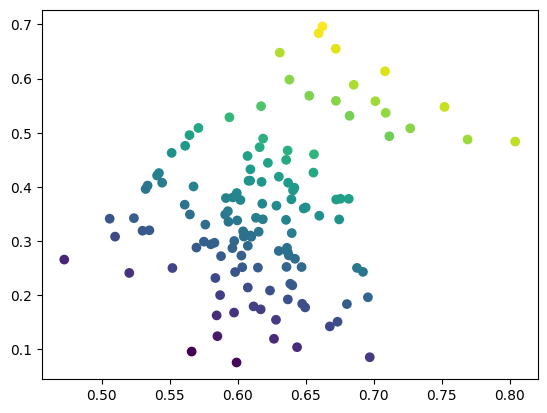

In [64]:
win_params1_list = model.conv1.window_params.detach().cpu().numpy()
win_params2_list = model.conv3.window_params.detach().cpu().numpy()
print(win_params1_list.shape)
print(win_params2_list.shape)
w1x = win_params1_list[..., 0].flatten()
w1y = win_params1_list[..., 1].flatten()
w1c = w1x + w1y
plt.scatter(w1x, w1y, c=w1c)

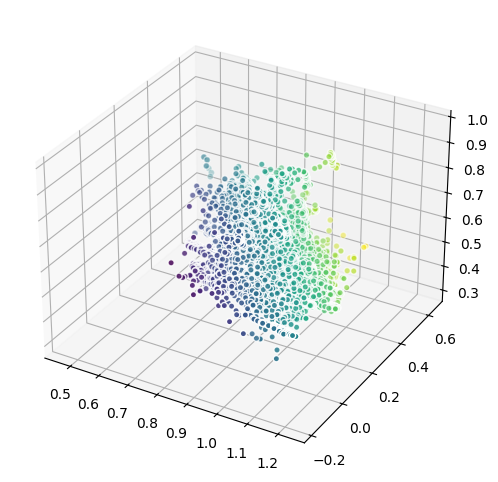

In [65]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection ='3d')

w2x = win_params2_list[...,0].flatten()
w2y = win_params2_list[...,1].flatten()
w2z = win_params2_list[...,2].flatten()
w2c = w2x + w2y
ax.set_xlim([w2x.min() - 0.1, w2x.max() + 0.1])
ax.set_ylim([w2y.min() - 0.1, w2y.max() + 0.1])
ax.set_zlim([w2z.min() - 0.1, w2z.max() + 0.1])
ax.scatter(w2x, w2y, w2z, c=w2c, edgecolor='white')

(array([2048., 3456., 3328., 2432., 2176., 1280.,  640.,  512.,  256.,
         256.]),
 array([0.0035846 , 0.0073439 , 0.01110321, 0.01486251, 0.01862181,
        0.02238112, 0.02614042, 0.02989972, 0.03365903, 0.03741833,
        0.04117763]),
 <BarContainer object of 10 artists>)

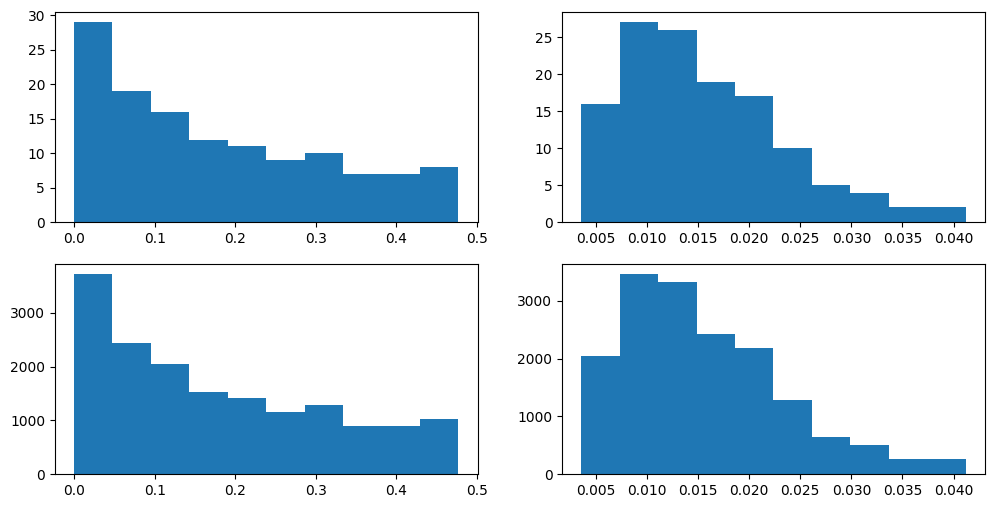

In [66]:
lowcut_bands1_m2 = model.conv1.lowcut_bands.detach().cpu().numpy()
bandwidths1_m2 = model.conv1.bandwidths.detach().cpu().numpy()
lowcut_bands2_m2 = model.conv3.lowcut_bands.detach().cpu().numpy()
bandwidths2_m2 = model.conv3.bandwidths.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(lowcut_bands1_m2.flatten())
axes[0,1].hist(bandwidths1_m2.flatten())
axes[1,0].hist(lowcut_bands2_m2.flatten())
axes[1,1].hist(bandwidths2_m2.flatten())

In [69]:
y_n_bin = 5
y_bins = np.linspace(0.,lowcut_bands1_m2.max(), y_n_bin+1)
x_n_bin = 3
x_bins = np.linspace(0.,bandwidths1_m2.max(), x_n_bin+1)

df = pd.DataFrame(data={
    'lowcut': lowcut_bands1_m2.flatten(), 
    'bandwidth': bandwidths1_m2.flatten(), 
    'window_params': list(rearrange(win_params1_list, 'h c p -> (h c) p')) 
})
df

,lowcut,bandwidth,window_params
0,0.000000,0.003585,"[0.5710712, 0.508707]"
1,0.003585,0.003878,"[0.5912855, 0.3793073]"
2,0.007463,0.004196,"[0.64696205, 0.25195375]"
3,0.011659,0.004540,"[0.67240363, 0.37662715]"
4,0.016199,0.004912,"[0.6526253, 0.5681696]"
...,...,...,...
123,0.389959,0.020805,"[0.6301825, 0.28163573]"
124,0.410764,0.021390,"[0.6093123, 0.43235847]"
125,0.432154,0.021991,"[0.6803164, 0.18357898]"
126,0.454145,0.022610,"[0.67461985, 0.3398262]"


In [67]:
import math
import seaborn as sns
sns.set_theme(style="dark")

In [70]:
win_length = 17
df['lowcut_bin'] = df['lowcut'].apply(lambda x: 
                   max(math.ceil(x/lowcut_bands1_m2.max()*y_n_bin)-1, 0))
df['bandwidth_bin'] = df['bandwidth'].apply(lambda x: 
                   max(math.ceil(x/bandwidths1_m2.max()*x_n_bin)-1, 0))
df['window'] = df['window_params'].apply(lambda x:
                   general_cosine_window(win_length, x).numpy().flatten())
df['order'] = df.apply(
    lambda x: (y_n_bin -1 - x['lowcut_bin'])*x_n_bin + x['bandwidth_bin'], 
    axis=1)
df['order'].value_counts()

order
12    48
7     20
9     14
10    14
4     13
1      8
2      7
5      4
Name: count, dtype: int64

In [71]:
h, c = lowcut_bands1_m2.shape
df_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=win_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=win_length),  
    'window': np.hstack(df['window'].values),
    'window_t': repeat(np.arange(win_length), 'k -> (h c k)', h=h, c=c, k=win_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'order': repeat(df['order'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=win_length)
})
df_expanded

,lowcut,bandwidth,window,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,0.062364,0,0,0,12,0
1,0.000000,0.003585,0.101087,1,0,0,12,0
2,0.000000,0.003585,0.211361,2,0,0,12,0
3,0.000000,0.003585,0.376397,3,0,0,12,0
4,0.000000,0.003585,0.571071,4,0,0,12,0
...,...,...,...,...,...,...,...,...
2171,0.476755,0.023245,0.673418,12,4,1,1,127
2172,0.476755,0.023245,0.615656,13,4,1,1,127
2173,0.476755,0.023245,0.566687,14,4,1,1,127
2174,0.476755,0.023245,0.533967,15,4,1,1,127


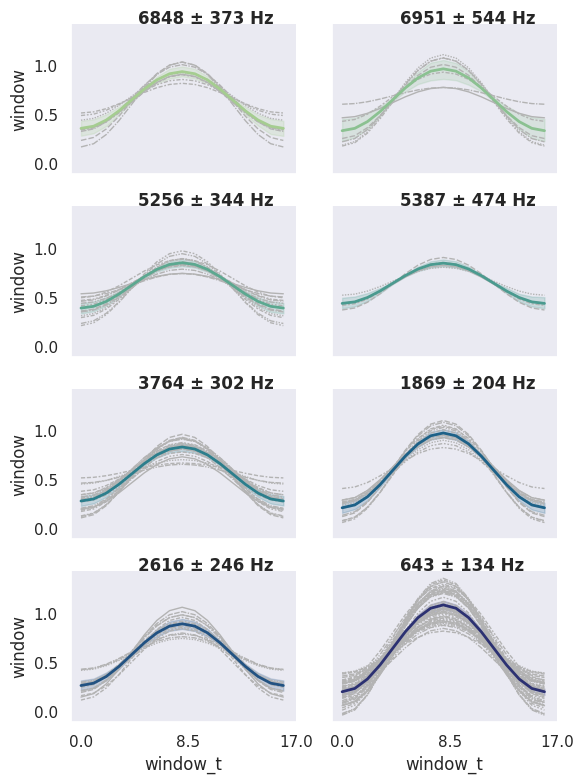

In [72]:
g = sns.relplot(
    data=df_expanded,
    x="window_t", 
    y='window', 
    col="order", hue="order",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = df_expanded[df_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.3, 1, subtitle, transform=ax.transAxes, fontweight="bold")

    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )
    
ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.tight_layout()

[ 0.00000000e+00 -5.27058071e-02 -2.11205151e-01 -4.76659184e-01
 -8.51055920e-01 -1.33729479e+00 -1.93931687e+00 -2.66229522e+00
 -3.51290849e+00 -4.49973525e+00 -5.63383007e+00 -6.92958571e+00
 -8.40606515e+00 -1.00891466e+01 -1.20151631e+01 -1.42375022e+01
 -1.68396645e+01 -1.99643366e+01 -2.38902362e+01 -2.93005519e+01
 -3.89782203e+01 -4.49406926e+01 -3.53460741e+01 -3.24789671e+01
 -3.15292086e+01 -3.16474180e+01 -3.25739960e+01 -3.42685052e+01
 -3.68636788e+01 -4.08035446e+01 -4.76829432e+01 -7.20154134e+01
 -4.84522389e+01 -4.39803253e+01 -4.20991555e+01 -4.14945461e+01
 -4.17867830e+01 -4.28747530e+01 -4.48284587e+01 -4.79579203e+01
 -5.32763101e+01 -6.77276609e+01 -5.89094487e+01 -5.25298907e+01
 -4.98539850e+01 -4.87076746e+01 -4.85469947e+01 -4.92049660e+01
 -5.06976993e+01 -5.32394545e+01 -5.75108930e+01 -6.66305559e+01
 -6.93195819e+01 -5.97533670e+01 -5.62035092e+01 -5.45475166e+01
 -5.39924257e+01 -5.42901605e+01 -5.54047727e+01 -5.74768372e+01
 -6.09784398e+01 -6.76680

<Axes: >

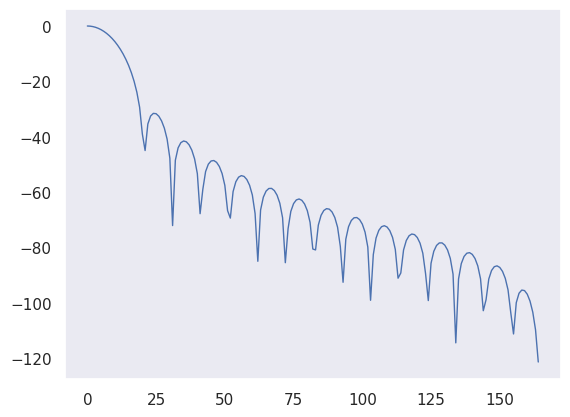

In [73]:
from IConNet.signal import get_window_freq_response

testresponse = get_window_freq_response(general_cosine_window(33,[0.5,0.5]))
tt = (testresponse.shape[-1]//2)
test_plt = testresponse[:tt]
print(test_plt)
sns.lineplot(test_plt, linewidth=1)

In [74]:
full_window_response_length = win_length*10
window_response_length = full_window_response_length
df['window_response'] = df['window'].apply(lambda x:
                   get_window_freq_response(x)[:window_response_length])
freq = np.fft.fftfreq(full_window_response_length,d=1/2)[:window_response_length]

In [75]:
h, c = lowcut_bands1_m2.shape
dff_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=window_response_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=window_response_length),  
    'window_response': np.hstack(df['window_response'].values),
    'window_t': repeat(freq, 
                       'k -> (h c k)', h=h, c=c, k=window_response_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, 
                         '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, 
                            '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'order': repeat(df['order'].values, 
                    '(h c) -> (h c k)', h=h, c=c, k=window_response_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=window_response_length)
})
dff_expanded

,lowcut,bandwidth,window_response,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,0.000000,0.000000,0,0,12,0
1,0.000000,0.003585,-0.060334,0.011765,0,0,12,0
2,0.000000,0.003585,-0.241679,0.023529,0,0,12,0
3,0.000000,0.003585,-0.545078,0.035294,0,0,12,0
4,0.000000,0.003585,-0.972302,0.047059,0,0,12,0
...,...,...,...,...,...,...,...,...
21755,0.476755,0.023245,-3.271243,-0.058824,4,1,1,127
21756,0.476755,0.023245,-2.041775,-0.047059,4,1,1,127
21757,0.476755,0.023245,-1.127682,-0.035294,4,1,1,127
21758,0.476755,0.023245,-0.494971,-0.023529,4,1,1,127


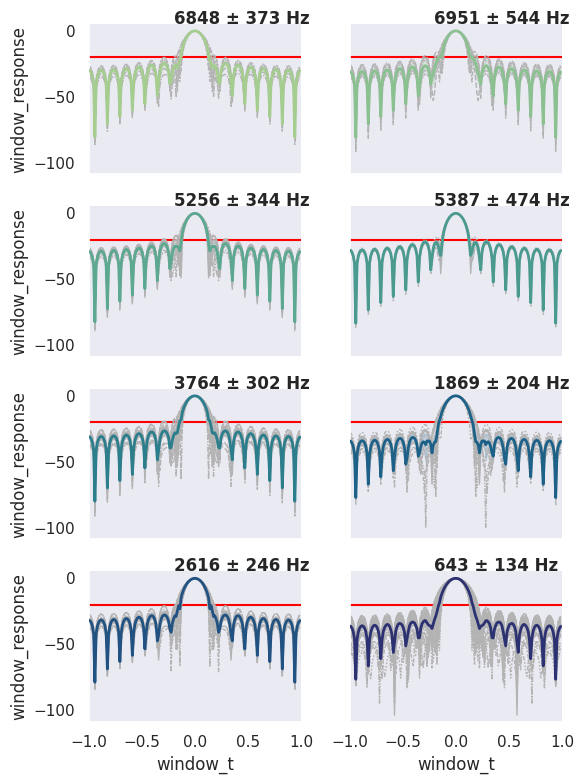

In [76]:
# sns.set(rc={'figure.figsize':(20,16)})
g = sns.relplot(
    data=dff_expanded,
    x="window_t", 
    y='window_response', 
    col="order", hue="order",
    # row='lowcut_bin', col='bandwidth_bin',
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = dff_expanded[dff_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.4, 1, subtitle, transform=ax.transAxes, fontweight="bold")
    ax.axhline(-20, color='red', zorder=1)
    
    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window_response", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )

    
    
# ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.set(xlim=[-1,1])
g.tight_layout()

In [77]:
model_path = "../M9_multi_firwin_heartsound_10epochs.pt"
torch.save(model.state_dict(), model_path)

Text(0.5, 1.0, 'training loss')

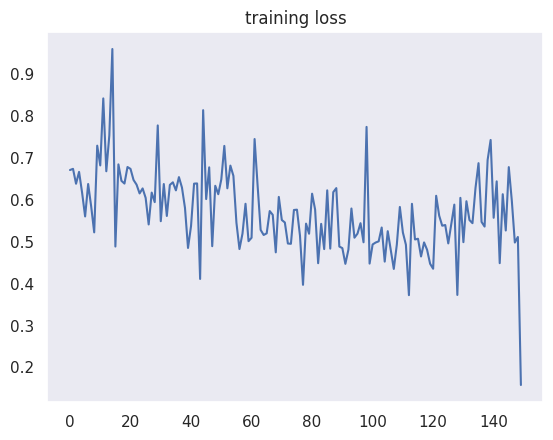

In [78]:
plt.plot(train_losses)
plt.title("training loss")

Text(0.5, 1.0, 'test accuracy')

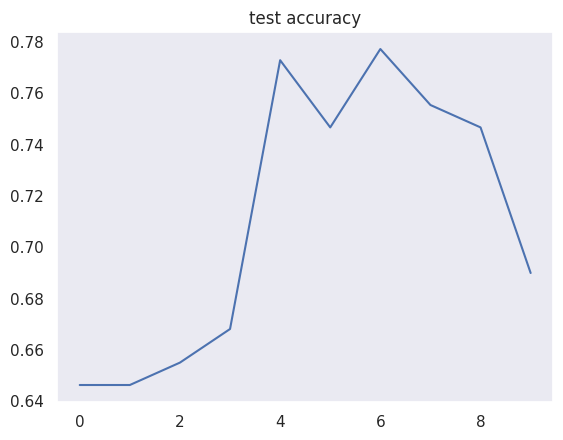

In [79]:
plt.plot(test_accuracy)
plt.title("test accuracy")

In [80]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

In [81]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                         | 0.05263157894736842/50 [00:00<06:34,  7.90s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.738693


  2%|█▊                                                                                        | 0.9999999999999996/50 [00:06<04:29,  5.50s/it]


Test Epoch: 11	Accuracy: 150/229 (66%)



  2%|█▉                                                                                         | 1.052631578947368/50 [00:07<04:59,  6.11s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.573093


  4%|███▌                                                                                      | 1.9999999999999984/50 [00:13<04:30,  5.64s/it]


Test Epoch: 12	Accuracy: 177/229 (77%)



  4%|███▋                                                                                       | 2.052631578947367/50 [00:13<04:57,  6.20s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.410533


  6%|█████▍                                                                                    | 3.0000000000000013/50 [00:20<04:17,  5.47s/it]


Test Epoch: 13	Accuracy: 177/229 (77%)



  6%|█████▌                                                                                      | 3.05263157894737/50 [00:20<04:45,  6.08s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.446125


  8%|███████▎                                                                                   | 4.000000000000004/50 [00:26<04:11,  5.46s/it]


Test Epoch: 14	Accuracy: 176/229 (77%)



  8%|███████▍                                                                                   | 4.052631578947373/50 [00:27<04:40,  6.10s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.449626


 10%|█████████                                                                                  | 4.999999999999999/50 [00:33<04:05,  5.45s/it]


Test Epoch: 15	Accuracy: 178/229 (78%)



 10%|█████████▏                                                                                 | 5.052631578947367/50 [00:34<04:33,  6.08s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.431254


 12%|██████████▉                                                                                | 5.999999999999994/50 [00:40<04:00,  5.46s/it]


Test Epoch: 16	Accuracy: 181/229 (79%)



 12%|███████████                                                                                | 6.052631578947362/50 [00:40<04:26,  6.07s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.541335


 14%|████████████▌                                                                             | 6.9999999999999885/50 [00:47<03:59,  5.56s/it]


Test Epoch: 17	Accuracy: 181/229 (79%)



 14%|████████████▊                                                                              | 7.052631578947357/50 [00:47<04:25,  6.19s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.518684


 16%|██████████████▌                                                                            | 7.999999999999983/50 [00:53<03:49,  5.47s/it]


Test Epoch: 18	Accuracy: 178/229 (78%)



 16%|██████████████▋                                                                            | 8.052631578947352/50 [00:54<04:15,  6.10s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.440981


 18%|████████████████▍                                                                          | 8.999999999999979/50 [01:00<03:44,  5.48s/it]


Test Epoch: 19	Accuracy: 177/229 (77%)



 18%|████████████████▍                                                                          | 9.052631578947347/50 [01:01<04:10,  6.11s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.483065


 20%|██████████████████▏                                                                        | 9.999999999999973/50 [01:07<03:39,  5.48s/it]


Test Epoch: 20	Accuracy: 180/229 (79%)



 20%|██████████████████                                                                        | 10.052631578947341/50 [01:07<04:04,  6.11s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.447793


 22%|███████████████████▊                                                                      | 10.999999999999968/50 [01:14<03:33,  5.48s/it]


Test Epoch: 21	Accuracy: 180/229 (79%)



 22%|███████████████████▉                                                                      | 11.052631578947336/50 [01:14<03:58,  6.11s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.615078


 24%|█████████████████████▌                                                                    | 11.999999999999963/50 [01:20<03:28,  5.50s/it]


Test Epoch: 22	Accuracy: 176/229 (77%)



 24%|█████████████████████▉                                                                     | 12.05263157894733/50 [01:21<03:52,  6.13s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.426883


 26%|███████████████████████▍                                                                  | 12.999999999999957/50 [01:27<03:21,  5.46s/it]


Test Epoch: 23	Accuracy: 181/229 (79%)



 26%|███████████████████████▍                                                                  | 13.052631578947326/50 [01:27<03:45,  6.09s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.467276


 28%|█████████████████████████▏                                                                | 13.999999999999952/50 [01:34<03:16,  5.45s/it]


Test Epoch: 24	Accuracy: 183/229 (80%)



 28%|█████████████████████████▌                                                                 | 14.05263157894732/50 [01:34<03:38,  6.08s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.378621


 30%|██████████████████████████▉                                                               | 14.999999999999947/50 [01:41<03:11,  5.46s/it]


Test Epoch: 25	Accuracy: 184/229 (80%)



 30%|███████████████████████████                                                               | 15.052631578947315/50 [01:41<03:32,  6.09s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.432161


 32%|████████████████████████████▊                                                             | 15.999999999999941/50 [01:47<03:05,  5.47s/it]


Test Epoch: 26	Accuracy: 187/229 (82%)



 32%|█████████████████████████████▏                                                             | 16.05263157894731/50 [01:48<03:27,  6.11s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.342878


 34%|██████████████████████████████▌                                                           | 16.999999999999968/50 [01:54<02:59,  5.45s/it]


Test Epoch: 27	Accuracy: 185/229 (81%)



 34%|██████████████████████████████▋                                                           | 17.052631578947338/50 [01:54<03:21,  6.10s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.366009


 36%|████████████████████████████████▍                                                         | 17.999999999999996/50 [02:01<02:55,  5.47s/it]


Test Epoch: 28	Accuracy: 188/229 (82%)



 36%|████████████████████████████████▍                                                         | 18.052631578947366/50 [02:01<03:15,  6.11s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.393268


 38%|██████████████████████████████████▏                                                       | 19.000000000000025/50 [02:08<02:50,  5.49s/it]


Test Epoch: 29	Accuracy: 182/229 (79%)



 38%|██████████████████████████████████▎                                                       | 19.052631578947395/50 [02:08<03:09,  6.13s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.273052


 40%|████████████████████████████████████                                                      | 20.000000000000053/50 [02:14<02:44,  5.48s/it]


Test Epoch: 30	Accuracy: 176/229 (77%)



 40%|████████████████████████████████████                                                      | 20.052631578947423/50 [02:15<03:03,  6.13s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.456494


 42%|██████████████████████████████████████▏                                                    | 21.00000000000008/50 [02:21<02:38,  5.47s/it]


Test Epoch: 31	Accuracy: 166/229 (72%)



 42%|██████████████████████████████████████▎                                                    | 21.05263157894745/50 [02:22<02:57,  6.12s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.479886


 44%|████████████████████████████████████████                                                   | 22.00000000000011/50 [02:28<02:30,  5.38s/it]


Test Epoch: 32	Accuracy: 176/229 (77%)



 44%|████████████████████████████████████████▏                                                  | 22.05263157894748/50 [02:28<02:48,  6.02s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.305184


 46%|█████████████████████████████████████████▊                                                 | 23.00000000000014/50 [02:34<02:24,  5.35s/it]


Test Epoch: 33	Accuracy: 181/229 (79%)



 46%|█████████████████████████████████████████▉                                                 | 23.05263157894751/50 [02:35<02:41,  6.00s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.443040


 48%|███████████████████████████████████████████▏                                              | 24.000000000000167/50 [02:41<02:19,  5.38s/it]


Test Epoch: 34	Accuracy: 188/229 (82%)



 48%|███████████████████████████████████████████▎                                              | 24.052631578947537/50 [02:42<02:36,  6.04s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.308892


 50%|█████████████████████████████████████████████                                             | 25.000000000000195/50 [02:48<02:18,  5.55s/it]


Test Epoch: 35	Accuracy: 180/229 (79%)



 50%|█████████████████████████████████████████████                                             | 25.052631578947565/50 [02:48<02:34,  6.20s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.338884


 52%|██████████████████████████████████████████████▊                                           | 26.000000000000224/50 [02:55<02:13,  5.57s/it]


Test Epoch: 36	Accuracy: 177/229 (77%)



 52%|██████████████████████████████████████████████▉                                           | 26.052631578947594/50 [02:55<02:29,  6.23s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.345707


 54%|████████████████████████████████████████████████▌                                         | 27.000000000000252/50 [03:02<02:05,  5.45s/it]


Test Epoch: 37	Accuracy: 169/229 (74%)



 54%|████████████████████████████████████████████████▋                                         | 27.052631578947622/50 [03:02<02:20,  6.14s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.546884


 56%|██████████████████████████████████████████████████▉                                        | 28.00000000000028/50 [03:08<02:00,  5.46s/it]


Test Epoch: 38	Accuracy: 176/229 (77%)



 56%|███████████████████████████████████████████████████                                        | 28.05263157894765/50 [03:09<02:14,  6.12s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.315637


 58%|████████████████████████████████████████████████████▊                                      | 29.00000000000031/50 [03:15<01:53,  5.42s/it]


Test Epoch: 39	Accuracy: 175/229 (76%)



 58%|████████████████████████████████████████████████████▉                                      | 29.05263157894768/50 [03:16<02:08,  6.12s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.812511


 60%|██████████████████████████████████████████████████████                                    | 30.000000000000338/50 [03:22<01:49,  5.49s/it]


Test Epoch: 40	Accuracy: 189/229 (83%)



 60%|██████████████████████████████████████████████████████                                    | 30.052631578947707/50 [03:22<02:01,  6.10s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.372098


 62%|███████████████████████████████████████████████████████▊                                  | 31.000000000000366/50 [03:29<01:43,  5.45s/it]


Test Epoch: 41	Accuracy: 194/229 (85%)



 62%|███████████████████████████████████████████████████████▉                                  | 31.052631578947736/50 [03:29<01:55,  6.10s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.350747


 64%|██████████████████████████████████████████████████████████▏                                | 32.00000000000039/50 [03:36<01:38,  5.48s/it]


Test Epoch: 42	Accuracy: 172/229 (75%)



 64%|██████████████████████████████████████████████████████████▎                                | 32.05263157894776/50 [03:36<01:51,  6.19s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.400833


 66%|████████████████████████████████████████████████████████████                               | 33.00000000000042/50 [03:42<01:33,  5.51s/it]


Test Epoch: 43	Accuracy: 189/229 (83%)



 66%|████████████████████████████████████████████████████████████▏                              | 33.05263157894779/50 [03:43<01:44,  6.14s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.439605


 68%|█████████████████████████████████████████████████████████████▉                             | 34.00000000000045/50 [03:49<01:29,  5.62s/it]


Test Epoch: 44	Accuracy: 178/229 (78%)



 68%|█████████████████████████████████████████████████████████████▉                             | 34.05263157894782/50 [03:50<01:40,  6.32s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.515021


 70%|███████████████████████████████████████████████████████████████                           | 35.000000000000476/50 [03:56<01:21,  5.42s/it]


Test Epoch: 45	Accuracy: 189/229 (83%)



 70%|███████████████████████████████████████████████████████████████                           | 35.052631578947846/50 [03:57<01:32,  6.16s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.297215


 72%|████████████████████████████████████████████████████████████████▊                         | 36.000000000000504/50 [04:03<01:20,  5.74s/it]


Test Epoch: 46	Accuracy: 190/229 (83%)



 72%|████████████████████████████████████████████████████████████████▉                         | 36.052631578947874/50 [04:04<01:27,  6.28s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.149625


 74%|███████████████████████████████████████████████████████████████████▎                       | 37.00000000000053/50 [04:10<01:10,  5.45s/it]


Test Epoch: 47	Accuracy: 190/229 (83%)



 74%|████████████████████████████████████████████████████████████████████▏                       | 37.0526315789479/50 [04:10<01:19,  6.14s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.219822


 76%|█████████████████████████████████████████████████████████████████████▏                     | 38.00000000000056/50 [04:17<01:05,  5.42s/it]


Test Epoch: 48	Accuracy: 183/229 (80%)



 76%|█████████████████████████████████████████████████████████████████████▎                     | 38.05263157894793/50 [04:17<01:12,  6.10s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.332966


 78%|██████████████████████████████████████████████████████████████████████▉                    | 39.00000000000059/50 [04:24<01:00,  5.54s/it]


Test Epoch: 49	Accuracy: 191/229 (83%)



 78%|███████████████████████████████████████████████████████████████████████                    | 39.05263157894796/50 [04:24<01:07,  6.17s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.291602


 80%|████████████████████████████████████████████████████████████████████████▊                  | 40.00000000000062/50 [04:31<00:56,  5.61s/it]


Test Epoch: 50	Accuracy: 184/229 (80%)



 80%|████████████████████████████████████████████████████████████████████████▉                  | 40.05263157894799/50 [04:31<01:01,  6.22s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.330286


 82%|██████████████████████████████████████████████████████████████████████████▌                | 41.00000000000065/50 [04:37<00:49,  5.51s/it]


Test Epoch: 51	Accuracy: 186/229 (81%)



 82%|██████████████████████████████████████████████████████████████████████████▋                | 41.05263157894802/50 [04:38<00:55,  6.17s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.399945


 84%|███████████████████████████████████████████████████████████████████████████▌              | 42.000000000000675/50 [04:44<00:44,  5.52s/it]


Test Epoch: 52	Accuracy: 184/229 (80%)



 84%|███████████████████████████████████████████████████████████████████████████▋              | 42.052631578948045/50 [04:45<00:49,  6.19s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.314016


 86%|███████████████████████████████████████████████████████████████████████████████             | 43.0000000000007/50 [04:51<00:38,  5.51s/it]


Test Epoch: 53	Accuracy: 178/229 (78%)



 86%|██████████████████████████████████████████████████████████████████████████████▎            | 43.05263157894807/50 [04:52<00:42,  6.17s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.192972


 88%|████████████████████████████████████████████████████████████████████████████████           | 44.00000000000073/50 [04:58<00:32,  5.37s/it]


Test Epoch: 54	Accuracy: 175/229 (76%)



 88%|█████████████████████████████████████████████████████████████████████████████████           | 44.0526315789481/50 [04:58<00:35,  6.04s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.259528


 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 45.00000000000076/50 [05:05<00:27,  5.43s/it]


Test Epoch: 55	Accuracy: 185/229 (81%)



 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 45.05263157894813/50 [05:05<00:29,  6.06s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.434175


 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 46.00000000000079/50 [05:11<00:21,  5.42s/it]


Test Epoch: 56	Accuracy: 194/229 (85%)



 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 46.05263157894816/50 [05:12<00:23,  6.07s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.211332


 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 47.00000000000082/50 [05:18<00:16,  5.45s/it]


Test Epoch: 57	Accuracy: 192/229 (84%)



 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 47.05263157894819/50 [05:18<00:17,  6.08s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.383251


 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48.000000000000846/50 [05:25<00:11,  5.56s/it]


Test Epoch: 58	Accuracy: 180/229 (79%)



 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 48.052631578948215/50 [05:25<00:11,  6.15s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.255359


 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 49.000000000000874/50 [05:32<00:05,  5.38s/it]


Test Epoch: 59	Accuracy: 196/229 (86%)



 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 49.052631578948244/50 [05:32<00:05,  6.04s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.251084


100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 49.94736842105353/50 [05:38<00:00,  5.95s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████| 50.0000000000009/50 [05:39<00:00,  6.78s/it]


Test Epoch: 60	Accuracy: 201/229 (88%)



In [82]:
model_path = "../M9_multi_firwin_heartsound_60epochs.pt"
torch.save(model.state_dict(), model_path)

Text(0.5, 1.0, 'training loss')

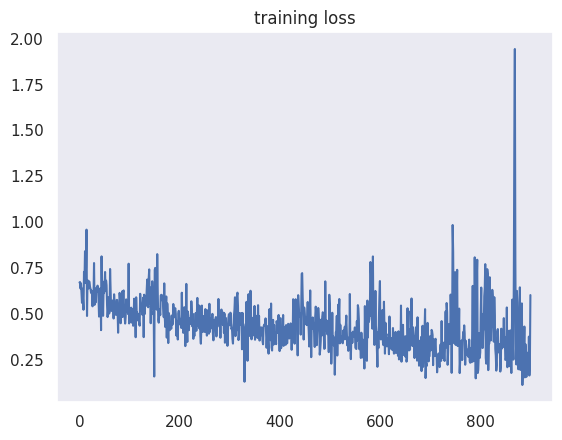

In [83]:
plt.plot(train_losses)
plt.title("training loss")

Text(0.5, 1.0, 'test accuracy')

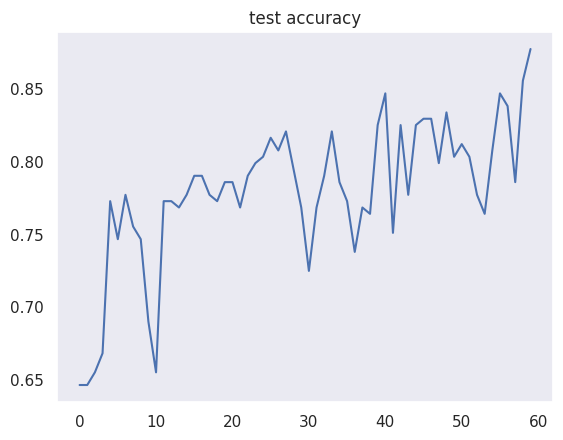

In [84]:
plt.plot(test_accuracy)
plt.title("test accuracy")

(128, 1, 2)
(128, 128, 3)


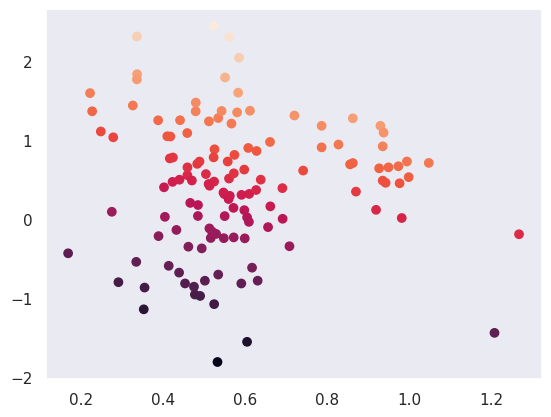

In [85]:
win_params1_list = model.conv1.window_params.detach().cpu().numpy()
win_params2_list = model.conv3.window_params.detach().cpu().numpy()
print(win_params1_list.shape)
print(win_params2_list.shape)
w1x = win_params1_list[..., 0].flatten()
w1y = win_params1_list[..., 1].flatten()
w1c = w1x + w1y
plt.scatter(w1x, w1y, c=w1c)

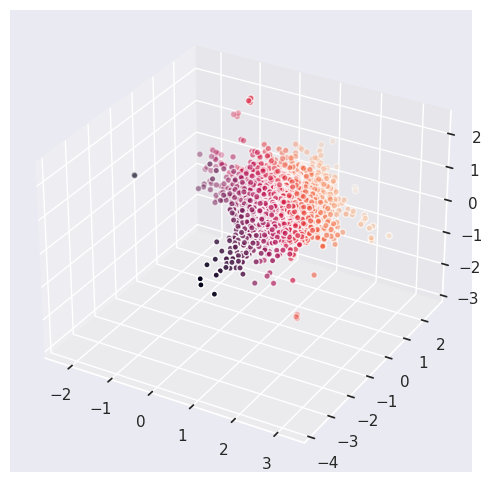

In [86]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection ='3d')

w2x = win_params2_list[...,0].flatten()
w2y = win_params2_list[...,1].flatten()
w2z = win_params2_list[...,2].flatten()
w2c = w2x + w2y
ax.set_xlim([w2x.min() - 0.1, w2x.max() + 0.1])
ax.set_ylim([w2y.min() - 0.1, w2y.max() + 0.1])
ax.set_zlim([w2z.min() - 0.1, w2z.max() + 0.1])
ax.scatter(w2x, w2y, w2z, c=w2c, edgecolor='white')

(array([2048., 3456., 3328., 2432., 2176., 1280.,  640.,  512.,  256.,
         256.]),
 array([0.0035846 , 0.0073439 , 0.01110321, 0.01486251, 0.01862181,
        0.02238112, 0.02614042, 0.02989972, 0.03365903, 0.03741833,
        0.04117763]),
 <BarContainer object of 10 artists>)

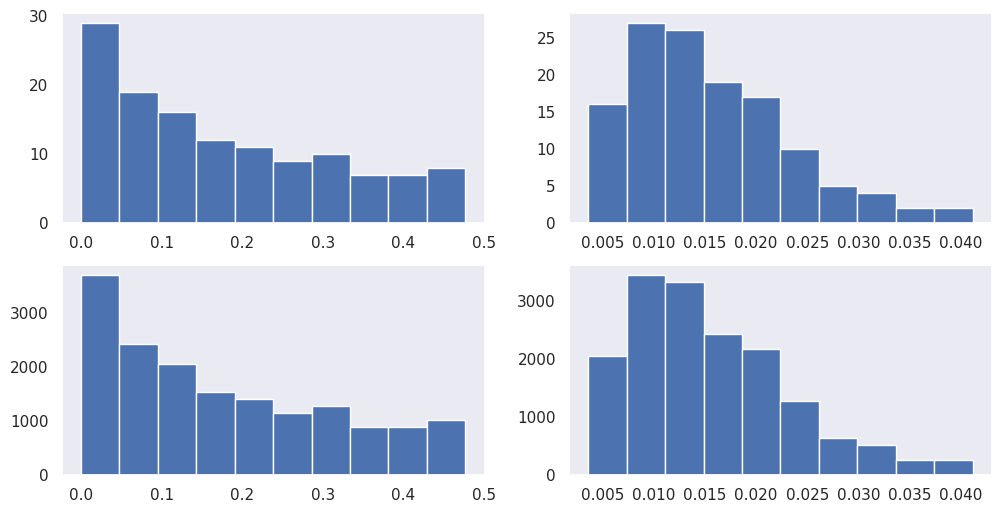

In [87]:
lowcut_bands1_m2 = model.conv1.lowcut_bands.detach().cpu().numpy()
bandwidths1_m2 = model.conv1.bandwidths.detach().cpu().numpy()
lowcut_bands2_m2 = model.conv3.lowcut_bands.detach().cpu().numpy()
bandwidths2_m2 = model.conv3.bandwidths.detach().cpu().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(lowcut_bands1_m2.flatten())
axes[0,1].hist(bandwidths1_m2.flatten())
axes[1,0].hist(lowcut_bands2_m2.flatten())
axes[1,1].hist(bandwidths2_m2.flatten())

In [88]:
y_n_bin = 5
y_bins = np.linspace(0.,lowcut_bands1_m2.max(), y_n_bin+1)
x_n_bin = 3
x_bins = np.linspace(0.,bandwidths1_m2.max(), x_n_bin+1)

df = pd.DataFrame(data={
    'lowcut': lowcut_bands1_m2.flatten(), 
    'bandwidth': bandwidths1_m2.flatten(), 
    'window_params': list(rearrange(win_params1_list, 'h c p -> (h c) p')) 
})
df

,lowcut,bandwidth,window_params
0,0.000000,0.003585,"[1.2665192, -0.18984407]"
1,0.003585,0.003878,"[0.7405523, 0.6172466]"
2,0.007463,0.004196,"[0.97263503, 0.67177904]"
3,0.011659,0.004540,"[0.92574286, 0.64570165]"
4,0.016199,0.004912,"[0.8266581, 0.9472456]"
...,...,...,...
123,0.389959,0.020805,"[0.5227404, 2.4496586]"
124,0.410764,0.021390,"[0.46951935, 0.4912453]"
125,0.432154,0.021991,"[0.60393727, -1.55355]"
126,0.454145,0.022610,"[0.55026144, 1.7974033]"


In [89]:
win_length = 17
df['lowcut_bin'] = df['lowcut'].apply(lambda x: 
                   max(math.ceil(x/lowcut_bands1_m2.max()*y_n_bin)-1, 0))
df['bandwidth_bin'] = df['bandwidth'].apply(lambda x: 
                   max(math.ceil(x/bandwidths1_m2.max()*x_n_bin)-1, 0))
df['window'] = df['window_params'].apply(lambda x:
                   general_cosine_window(win_length, x).numpy().flatten())
df['order'] = df.apply(
    lambda x: (y_n_bin -1 - x['lowcut_bin'])*x_n_bin + x['bandwidth_bin'], 
    axis=1)
df['order'].value_counts()

order
12    48
7     20
9     14
10    14
4     13
1      8
2      7
5      4
Name: count, dtype: int64

In [90]:
h, c = lowcut_bands1_m2.shape
df_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=win_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=win_length),  
    'window': np.hstack(df['window'].values),
    'window_t': repeat(np.arange(win_length), 'k -> (h c k)', h=h, c=c, k=win_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'order': repeat(df['order'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=win_length)
})
df_expanded

,lowcut,bandwidth,window,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,1.456363,0,0,0,12,0
1,0.000000,0.003585,1.441912,1,0,0,12,0
2,0.000000,0.003585,1.400759,2,0,0,12,0
3,0.000000,0.003585,1.339169,3,0,0,12,0
4,0.000000,0.003585,1.266519,4,0,0,12,0
...,...,...,...,...,...,...,...,...
2171,0.476755,0.023245,0.597033,12,4,1,1,127
2172,0.476755,0.023245,0.356045,13,4,1,1,127
2173,0.476755,0.023245,0.151745,14,4,1,1,127
2174,0.476755,0.023245,0.015236,15,4,1,1,127


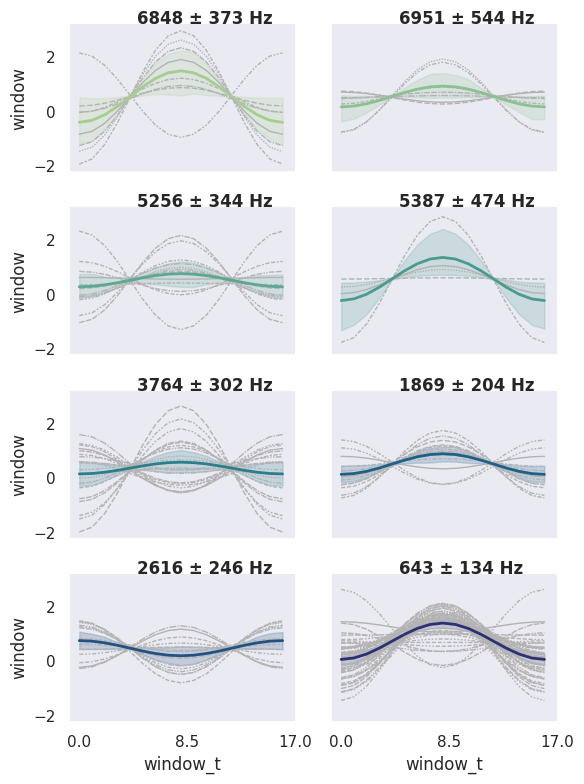

In [91]:
g = sns.relplot(
    data=df_expanded,
    x="window_t", 
    y='window', 
    col="order", hue="order",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = df_expanded[df_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.3, 1, subtitle, transform=ax.transAxes, fontweight="bold")

    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )
    
ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.tight_layout()

In [92]:
full_window_response_length = win_length*10
window_response_length = full_window_response_length
df['window_response'] = df['window'].apply(lambda x:
                   get_window_freq_response(x)[:window_response_length])
freq = np.fft.fftfreq(full_window_response_length,d=1/2)[:window_response_length]
h, c = lowcut_bands1_m2.shape
dff_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=window_response_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=window_response_length),  
    'window_response': np.hstack(df['window_response'].values),
    'window_t': repeat(freq, 
                       'k -> (h c k)', h=h, c=c, k=window_response_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, 
                         '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, 
                            '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'order': repeat(df['order'].values, 
                    '(h c) -> (h c k)', h=h, c=c, k=window_response_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=window_response_length)
})
dff_expanded

,lowcut,bandwidth,window_response,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,0.000000,0.000000,0,0,12,0
1,0.000000,0.003585,-0.155971,0.011765,0,0,12,0
2,0.000000,0.003585,-0.631493,0.023529,0,0,12,0
3,0.000000,0.003585,-1.451207,0.035294,0,0,12,0
4,0.000000,0.003585,-2.663288,0.047059,0,0,12,0
...,...,...,...,...,...,...,...,...
21755,0.476755,0.023245,-1.126078,-0.058824,4,1,1,127
21756,0.476755,0.023245,-0.715730,-0.047059,4,1,1,127
21757,0.476755,0.023245,-0.400466,-0.035294,4,1,1,127
21758,0.476755,0.023245,-0.177317,-0.023529,4,1,1,127


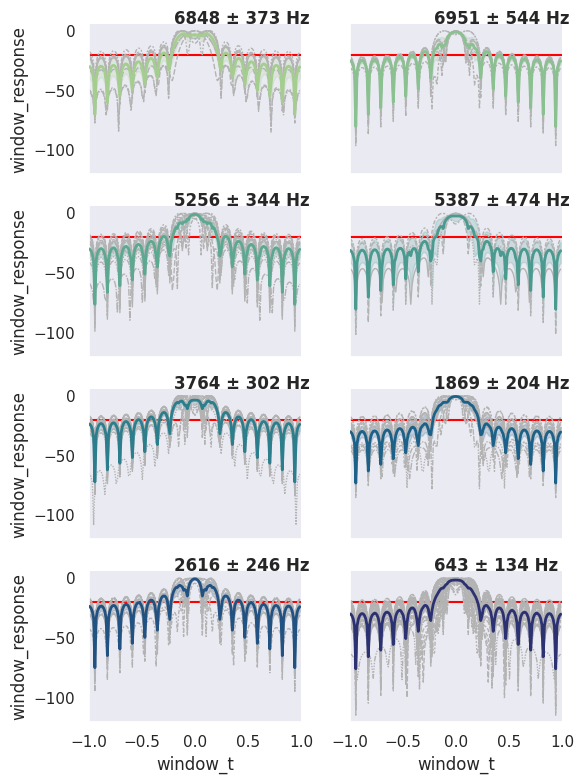

In [93]:
# sns.set(rc={'figure.figsize':(20,16)})
g = sns.relplot(
    data=dff_expanded,
    x="window_t", 
    y='window_response', 
    col="order", hue="order",
    # row='lowcut_bin', col='bandwidth_bin',
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = dff_expanded[dff_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.4, 1, subtitle, transform=ax.transAxes, fontweight="bold")
    ax.axhline(-20, color='red', zorder=1)
    
    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window_response", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )

    
    
# ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.set(xlim=[-1,1])
g.tight_layout()